In [191]:
import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

I borrow code and ideas from

- ["Understanding Generalization through Visuzalizations"](https://arxiv.org/abs/1906.03291) (Huang et al, 2019) in their repository [`wronnyhuang/gen-viz`](https://github.com/wronnyhuang/gen-viz)
- ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913) (Li et al, 2018) in their repository [`tomgoldstein/loss-landscape`](https://github.com/tomgoldstein/loss-landscape)

In [210]:
### Adapted from `gen-viz`
def twospirals(n_points, noise=0.5, rng=None):
  """
    Returns the two spirals dataset.
  """
  if rng is None:
    rng = np.random.default_rng(42)

  n = np.sqrt(rng.uniform(size=(n_points, 1))) * 600 * (2*np.pi)/360
  d1x = -1.5*np.cos(n)*n + rng.uniform(size=(n_points, 1)) * noise
  d1y =  1.5*np.sin(n)*n + rng.uniform(size=(n_points, 1)) * noise
  return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

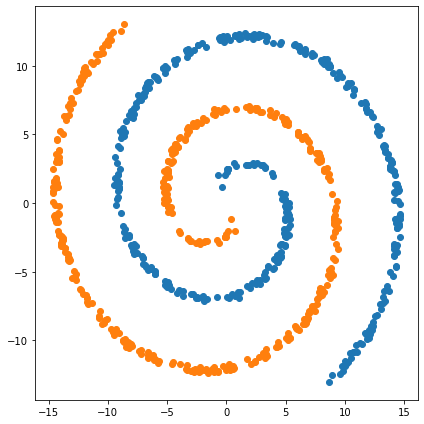

In [220]:
N = 400

X, Y = twospirals(N)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(*X[Y == 0].T)
ax.scatter(*X[Y == 1].T)

fig.tight_layout()
fig.show()

### Prep dataset and dataloaders

In [221]:
class Swissroll(Dataset):
  def __init__(self, X, Y):
    self.X, self.Y = X, Y
  
  def __len__(self): return len(self.Y)

  def __getitem__(self, idx): return self.X[idx], self.Y[idx]

In [253]:
X, Y = twospirals(N)
dataset = Swissroll(tensor(X, dtype=torch.float), tensor(Y, dtype=torch.int64))

test_size = 0.1
random_split_rng = torch.Generator()
train_rng = torch.Generator()

train_batch_size = 16
test_batch_size = 16

random_split_rng.manual_seed(42)
train_set, test_set = random_split(dataset, (1 - test_size, test_size), generator=random_split_rng)

train_loader = DataLoader(train_set, train_batch_size, shuffle=True, generator=train_rng)
train_loader.num_samples = len(train_set)
test_loader = DataLoader(test_set, test_batch_size, shuffle=False)
test_loader.num_samples = len(test_set)

### Define model

In [735]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(42)

    # This appears to be what Huang et al used
    num_hidden = (23, 16, 26, 32, 28, 31)

    num_hidden = (16, 16, 16, 16, 16, 16)

    relu = nn.ReLU()

    layers = [[nn.Linear(prev, post), relu] for prev, post in zip(num_hidden[:-1], num_hidden[1:])]
    layers = sum(layers, [])

    self.seq = nn.Sequential(
      nn.Linear(2, num_hidden[0]), # Input data is two-dimensional,
      relu,
      *layers,
      nn.Linear(num_hidden[-1], 2) # Two output classes
    )

    self.num_params = sum([p.numel() for p in self.parameters() if p.requires_grad])

  def forward(self, X):
    return self.seq(X)
  
  # Inspired by `gen-viz`
  def infer(self, X):
    return torch.argmax(self(X), axis=1)

  # Record the weights at a specific point in time as a reference
  def record_weights(self): self.weights = [p.data for p in self.parameters()]
  
print(f"number of parameters: {Model().num_params}")

number of parameters: 1518


### Get weight directions and set model weights

In [766]:
### Adapted from `loss-landscape`
def get_random_weights(weights, rng):
  """
    Produce a random direction that is a list of random Gaussian tensors
    with the same shape as the network's weights, so one direction entry per weight.
  """
  return [torch.randn(w.size(), generator=rng) for w in weights]

def scale_dirs(weights, dirs):
  for dir_i in dirs:
    for d, w in zip(dir_i, weights):
      d.mul_(w.norm() / d.norm())

def set_weights(model, dirs, steps):
  changes = [d0 * steps[0] + d1 * steps[1] for (d0, d1) in zip(*dirs)]

  for (p, w, change) in zip(model.parameters(), model.weights, changes):
    p.data = w + change

In [774]:
rng = torch.Generator().manual_seed(42)
model = Model()
model.record_weights()

dirs = [get_random_weights(model.weights, rng) for _ in range(2)]
scale_dirs(model.weights, dirs)

steps = (0.0, 1)

set_weights(model, dirs, steps)

### Train and test loops

In [443]:
def train(model, opt, num_epochs, train_loader, print_every=10):
  obj = nn.CrossEntropyLoss()
  model.train()

  seeds = np.arange(num_epochs)

  # Mean loss per sample
  mean_train_losses = [None] * num_epochs
  accs = [None] * num_epochs

  for epoch in range(num_epochs):
    # Train
    train_rng.manual_seed(int(seeds[epoch]))

    epoch_loss = 0
    correct = 0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      opt.zero_grad()

      # Predict, get loss, backprop, step
      pred = model(x)

      loss = obj(pred, y)
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
      correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

    # Record
    mean_train_losses[epoch] = epoch_loss / train_loader.num_samples
    accs[epoch] = correct / train_loader.num_samples

    if epoch % print_every == 0:
      print(f"epoch: {epoch:>5} | mean loss: {mean_train_losses[epoch]:.3f} | accuracy: {accs[epoch]:.3f}")
    
  return tensor(mean_train_losses), tensor(accs)

def test(model, test_loader):
  obj = nn.CrossEntropyLoss()
  model.eval()

  loss = 0
  correct = 0
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)

    loss += obj(pred, y).item()
    correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

  mean_loss = loss / len(test_set)
  acc = correct / len(test_set)

  return mean_loss, acc

In [444]:
num_epochs = 12
lr = 1e-2
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
obj = nn.CrossEntropyLoss()

mean_train_losses, train_accs = train(model, opt, num_epochs, train_loader, print_every=10)

mean_test_loss, test_acc = test(model, test_loader)

epoch:     0 | mean loss: 0.040 | accuracy: 0.642
epoch:    10 | mean loss: 0.006 | accuracy: 0.969


### Plot decision boundary

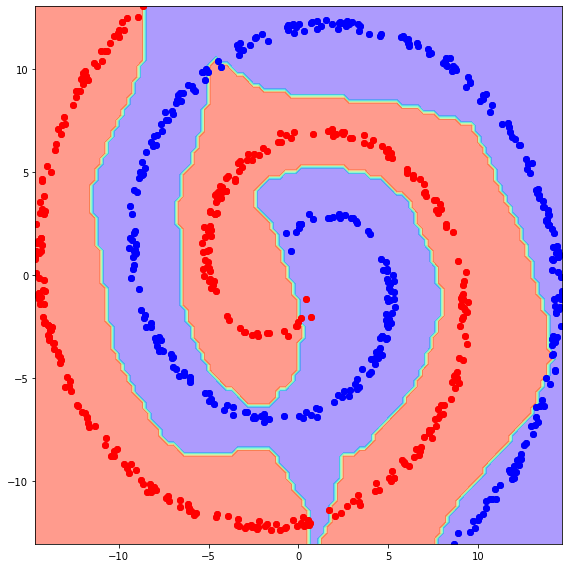

In [445]:
### Adapted from `gen-viz`

# Predict the classification on a grid of points
model.eval()

xn = yn = 100
xls = np.linspace(X[:, 0].min(), X[:, 0].max(), xn)
yls = np.linspace(X[:, 1].min(), X[:, 1].max(), yn)

xx1, xx2 = np.meshgrid(xls, yls)

xstack = np.column_stack([xx1.ravel(), xx2.ravel()])
pred = model.infer(tensor(xstack, dtype=torch.float))
yy = np.reshape(pred, xx1.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))


# Plot decision boundary
ax.contourf(xx1, xx2, yy, alpha=0.5, cmap="rainbow")

# Plot train data
train_mask = train_set[:][1] == 1
ax.scatter(*train_set[:][0][train_mask].T, color="red")
ax.scatter(*train_set[:][0][~train_mask].T, color="blue")

# Plot test data
train_mask = train_set[:][1] == 1
ax.scatter(*train_set[:][0][train_mask].T, color="red")
ax.scatter(*train_set[:][0][~train_mask].T, color="blue")

fig.tight_layout()
fig.show()